# 1 - Dataset

The 'Amazon-Reviews-Dataset 2023' is a comprehensive dataset containing all the reviews from Amazon.com, and contains features such as reviews, ratings, metadata such as images, descriptions & price, and links to things like 'bought together' graphs.

Does it ever bother you when looking through reviews for a product on Amazon, and behold! some ninconpoop has decided to leave a 5-Star rating stating 'Product never delivered' or 'I hated it'. What if you never had to see that again? Amazon could implement sentiment analysis to screen their reviews before they are applied to the product page, and hey-presto, world peace has been achieved.

The aim of this project is to to train different Natural Language Processing algorithms using the dataset and compare them when evaluating the sentiment on a given subset of reviews.

# Dataset Loading & Pre-processing

### Data Fields from the Dataset

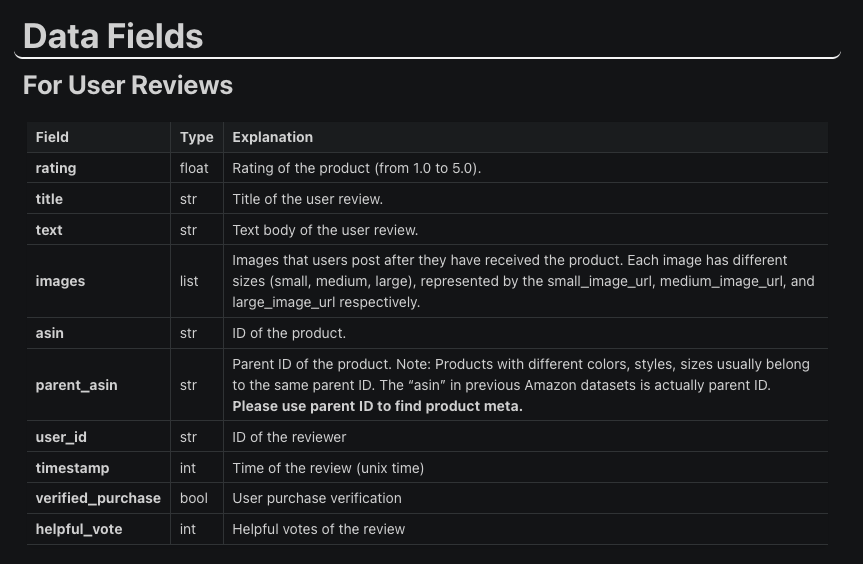

### Approach
Two approaches will be used to show the accuracy of each algorithm; One will use only the description text of the review, and in the other, the title and description text of each review will be combined to see if this will provide a more accurate analysis. The 'rating' will be used as the 'ground truth' to compare against for both.

The dataset provides values between 1 and 5 indicating the 5-Star category rating system used. The ratings of each review will be flattened to '0' or '1' to indicate 'negative' or 'positive' reviews, respectively.

### Example

'This product was great!' --> may indicate a positive review.

'This product was terrible and I hate it'  --> may indicate a negative review.

'This product is one of the seven wonders of the world' --> may indicate a positive review.

### Representation Learning

The dataset is loaded in using the HuggingFace datasets library and saved to a .pkl file using the Pickle library. All the unnecessary columns were dropped from the dataset, then loaded into two separate pandas dataframes. This was to split the dataset into the two approaches used to train the models. The 'rating' columns were then flattened and the two approaches were converted to lowercase and de-punctuated, then two training splits were created to be loaded into the models.

In [54]:
import sys
print(sys.executable)

/Users/douglashill/Developer/aiEnv/bin/python


In [55]:
# from google.colab import drive
# drive.mount('/content/drive')

In [56]:
%pip install datasets
%pip install matplotlib
%pip install pickle-utils
%pip install nltk
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install torch
%pip install tensorflow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [57]:
import datasets
from datasets import load_dataset
import numpy as np
import pandas as pd
import pickle

def save_data(data, filename):
    # with open(f'/content/drive/MyDrive/Colab Notebooks/{filename}', 'wb') as f:
    with open(f'/Users/douglashill/Developer/AI/{filename}', 'wb') as f:

        pickle.dump(data, f)
    print(f"Data saved to {filename}")


# dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", trust_remote_code=True)

# Smaller dataset
sDataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Handmade_Products", trust_remote_code=True)

save_data((sDataset['full']), 'dataset.pkl')

Data saved to dataset.pkl


In [58]:
def load_data(filename):
    # with open(f'/content/drive/MyDrive/Colab Notebooks/{filename}', 'rb') as f:
    with open(f'/Users/douglashill/Developer/AI/{filename}', 'rb') as f:
        return pickle.load(f)

dataset = load_data('dataset.pkl')
df = pd.DataFrame(dataset)
df.info()

df = df.drop(columns=['images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'])
df.info()

# df['rating'] = df['rating'].astype(str)
# df.info()
# print(df)

display(df)
save_data(df, 'pDataset.pkl')

# rSentiment = df.groupby('rating').count()['combined_text'].reset_index().sort_values(by='combined_text', ascending=False)
# print(rSentiment)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664162 entries, 0 to 664161
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             664162 non-null  float64
 1   title              664162 non-null  object 
 2   text               664162 non-null  object 
 3   images             664162 non-null  object 
 4   asin               664162 non-null  object 
 5   parent_asin        664162 non-null  object 
 6   user_id            664162 non-null  object 
 7   timestamp          664162 non-null  int64  
 8   helpful_vote       664162 non-null  int64  
 9   verified_purchase  664162 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 46.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664162 entries, 0 to 664161
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rating  664162 non-null  float64
 1   

,rating,title,text
0,5.0,Beautiful colors,I bought one for myself and one for my grandda...
1,5.0,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...
2,5.0,Great,As pictured. Used a frame from the dollar stor...
3,5.0,Well made and so beautiful,"This is beyond beautiful. So shiny, the size ..."
4,5.0,Smells just like the real thing!,Oh wow what a pleasant surprise! This smells g...
...,...,...,...
664157,1.0,This can't be the real thing! GROSS!,Came without the packaging in a felt bag; and ...
664158,5.0,Great scrubby,Great quality product. More than I like to pay...
664159,5.0,Five Stars,Beautiful notebook—gave it as a gift and recip...
664160,5.0,This is a beautiful picture,I place this picture over the head of my bed.


Data saved to pDataset.pkl


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
import pickle

process = load_data('pDataset.pkl')
dfx = pd.DataFrame(process)
dfy = pd.DataFrame(process)
dfy = dfy.drop(columns=['title'])

# Function for transforming the text to lowercase & removing punctuation
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

# Process combined title & text set
dfx['rating'] = dfx['rating'].apply(lambda x: 0 if 1 <= x <= 3 else 1 if 4 <= x <= 5 else x)
display(dfx['rating'])

dfx['combined_text'] = dfx['title'] + ' ' + dfx['text']
dfx['combined_text'] = dfx['combined_text'].apply(preprocess_text)
display(dfx['combined_text'])

dfx = dfx.drop(columns=['title', 'text'])

xSentiment = dfx.groupby('rating').count()['combined_text'].reset_index().sort_values(by='combined_text', ascending=False)
print(xSentiment)

save_data(dfx, 'combinedDataset.pkl')

# Process text set
dfy['rating'] = dfy['rating'].apply(lambda x: 0 if 1 <= x <= 3 else 1 if 4 <= x <= 5 else x)
display(dfy['rating'])

dfy['text'] = dfy['text'].apply(preprocess_text)
display(dfy['text'])

ySentiment = dfy.groupby('rating').count()['text'].reset_index().sort_values(by='text', ascending=False)
print(ySentiment)

save_data(dfy, 'textDataset.pkl')

# Training data for combined title & text set
X_train, X_test, y_train, y_test = train_test_split(dfx['combined_text'], dfx['rating'], test_size=0.2, random_state=42)
save_data((X_train, X_test, y_train, y_test), 'trainCombined.pkl')

# Training data for text only set
X_train, X_test, y_train, y_test = train_test_split(dfy['text'], dfy['rating'], test_size=0.2, random_state=42)
save_data((X_train, X_test, y_train, y_test), 'trainText.pkl')

0         1
1         1
2         1
3         1
4         1
         ..
664157    0
664158    1
664159    1
664160    1
664161    1
Name: rating, Length: 664162, dtype: int64

0         beautiful colors i bought one for myself and o...
1         you simply must order order more than one i’ve...
2         great as pictured used a frame from the dollar...
3         well made and so beautiful this is beyond beau...
4         smells just like the real thing oh wow what a ...
                                ...                        
664157    this cant be the real thing gross came without...
664158    great scrubby great quality product more than ...
664159    five stars beautiful notebook—gave it as a gif...
664160    this is a beautiful picture i place this pictu...
664161    woodwork is perfect identical and straight nat...
Name: combined_text, Length: 664162, dtype: object

   rating  combined_text
1       1         572095
0       0          92067
Data saved to combinedDataset.pkl


0         1
1         1
2         1
3         1
4         1
         ..
664157    0
664158    1
664159    1
664160    1
664161    1
Name: rating, Length: 664162, dtype: int64

0         i bought one for myself and one for my grandda...
1         i’ve ordered three bows so far have not been d...
2         as pictured used a frame from the dollar store...
3         this is beyond beautiful  so shiny the size is...
4         oh wow what a pleasant surprise this smells gr...
                                ...                        
664157    came without the packaging in a felt bag and t...
664158    great quality product more than i like to pay ...
664159    beautiful notebook—gave it as a gift and recip...
664160         i place this picture over the head of my bed
664161    natural wood most important when considering e...
Name: text, Length: 664162, dtype: object

   rating    text
1       1  572095
0       0   92067
Data saved to textDataset.pkl
Data saved to trainCombined.pkl
Data saved to trainText.pkl


# NLP Algorithms

I will be using two algorithms as part of the sentiment analysis process. Each one will be implemented, evaluated to show the overall accuracy, and tested with new samples to demonstrate the accuracy.

In [60]:
new_reviews = [
    "I absolutely love this product! It exceeded all my expectations and has become an essential part of my daily routine. The quality is top-notch, and it works exactly as described. The design is sleek and modern, making it a great addition to my home. I highly recommend this to anyone looking for a reliable and efficient solution. Worth every penny!",
    "I am very disappointed with this product. It did not meet my expectations at all. The quality feels cheap, and it stopped working properly after just a few uses. The description was misleading, and I feel like I wasted my money. I would not recommend this to anyone. Save your money and look for a better alternative.",
    "The product is okay, but it has its pros and cons. It performs its basic functions as advertised, but there's nothing particularly outstanding about it. The quality is average, and while it's not the best I've used, it's not the worst either. It's a decent option if you're on a budget, but don't expect anything extraordinary. Overall, it's a fair product for the price.",
    "I'm thoroughly unimpressed with this purchase. The product arrived damaged and customer service was unhelpful. Even when it works, the performance is subpar at best. It's overpriced for what you get, and I regret not reading more reviews before buying. Avoid this disappointment.",
    "The product is adequate for basic needs. It functions as intended, but don't expect any bells and whistles. The build quality is average, and it gets the job done without any fuss. If you're looking for something simple and straightforward, this might suffice.",
    "I'm absolutely thrilled with this product! It's exceeded my expectations in every way. The quality is superb, and it's made my life so much easier. It's rare to find something that delivers on all its promises, but this does. A fantastic investment!",
    "What a letdown. The product is poorly made and started malfunctioning within days. The instructions are confusing, and when I reached out for help, I was met with indifference. It's a waste of money and time. I strongly advise against purchasing this.",
    "This product is middle-of-the-road. It has some good features, but also a few drawbacks. The performance is inconsistent - sometimes it works great, other times it's frustrating. It's not bad for the price, but there's definitely room for improvement.",
    "I can't say enough good things about this product! It's revolutionized my daily routine. The efficiency and ease of use are outstanding. It's durable, well-designed, and worth every penny. If you're on the fence, take the plunge - you won't regret it!",
    "Extremely disappointed with this purchase. The product is nothing like advertised. It's flimsy, unreliable, and poorly designed. I've had nothing but problems since I bought it. Save yourself the headache and look for something else.",
    "The product is okay, nothing more, nothing less. It does what it's supposed to do without any frills. The quality is decent for the price point, but don't expect it to last forever. It's a reasonable choice if you have modest expectations.",
    "This product has been a pleasant surprise. While not perfect, it offers good value for money. It's easy to use and performs most tasks well. There are a few minor issues, but overall, it's a solid purchase that I'm satisfied with.",
    "This product is a complete disaster. It's poorly made, unreliable, and a waste of money. I've had nothing but problems since day one, and customer support has been utterly useless. I wish I could give it zero stars. Do yourself a favor and stay far away from this nightmare.",
    "The product is decent enough, I suppose. It does what it's meant to do without any major issues, but it doesn't particularly excel in any area. The quality is average, and the performance is just okay. It's not bad for the price, but don't expect to be wowed.",
    "What an incredible product! It's exceeded my expectations in every possible way. The attention to detail is remarkable, and it's clear that a lot of thought went into its design. It's not only functional but also a pleasure to use. I can't recommend it highly enough!",
    "I'm thoroughly disappointed with this purchase. The product feels cheap and flimsy, and it started malfunctioning after just a few uses. The advertised features are misleading, and it's nowhere near as effective as claimed. Save your money and look for better alternatives.",
    "This product is a mixed bag. It has some good points, like its ease of use and compact design. However, it also has some drawbacks, such as inconsistent performance and average build quality. It's okay for the price, but there's definitely room for improvement.",
    "I'm blown away by how good this product is! It's incredibly efficient, user-friendly, and has made a significant positive impact on my life. The quality is top-notch, and it's clear that no corners were cut in its production. It's a fantastic investment that I wholeheartedly recommend.",
    "What a letdown this product has been. It's frustratingly unreliable, poorly designed, and doesn't deliver on any of its promises. I've wasted so much time trying to make it work properly. It's overpriced and underperforms - definitely not worth the hassle.",
    "The product is alright, I guess. It does its job without any major hiccups, but it's not particularly impressive either. The quality is passable, and it performs adequately most of the time. If you're looking for something basic that gets the job done, this might suffice.",
    "I'm pleasantly surprised by this product. While it's not perfect, it offers good value for the price. It's user-friendly, performs well for most tasks, and has a few neat features. There are some minor issues, but overall, I'm quite satisfied with my purchase."
]

## Naive Bayes (Mixture of Multi-Nom, Complement, Tfidf & Count)

Naive Bayes is a family of probabilistic classifiers based on Bayes' theorem, widely used for various classification tasks, particularly in text classification and sentiment analysis. These algorithms are known for their simplicity, speed, and effectiveness, especially when dealing with high-dimensional data such as text.

The choice of Naive Bayes variant can significantly impact classification results, I have chosen two to demonstrate:
MultinomialNB is often the go-to choice for text classification tasks due to its effectiveness with word count features. It performs well when dealing with multiple classes and large vocabularies.
ComplementNB addresses some limitations of the standard MultinomialNB, particularly for imbalanced datasets. It calculates the probability of an item not belonging to each class, which can lead to improved performance when one class significantly outnumbers the others.

### Performance

Naive Bayes classifiers are known for their efficiency and simplicity, but their performance can vary depending on the specific problem and dataset:
1. They often provide a good baseline for comparison with more complex models (hence my choice).
2. They can be particularly effective when the 'independence assumption' holds true or when the violations of this assumption don't significantly impact the classification decision.
3. They tend to perform well with high-dimensional data, making them suitable for text classification tasks with larger vocabularies.
4. For imbalanced datasets, ComplementNB may outperform standard MultinomialNB, which is why I included it after seeing the distribution from the last step (x/ySentiment).

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# X_train, X_test, y_train, y_test = load_data('trainText.pkl')
X_train, X_test, y_train, y_test = load_data('trainCombined.pkl')

# 1. Using Countvectoriser
vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize and train the Naive Bayes classifier
# 2. Using MultinomialNB
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train_vectorized, y_train)

# 3. Using Multinomial with weights
# Calculate class weights
n_samples = len(y_train)
n_classes = len(set(y_train))
class_weights = {0: n_samples / (n_classes * np.sum(y_train == 0)),
                 1: n_samples / (n_classes * np.sum(y_train == 1))}

weighted_nb = MultinomialNB(class_prior=[class_weights[0], class_weights[1]])
weighted_nb.fit(X_train_vectorized, y_train)

# 4. Using ComplementNB
complement_nb = ComplementNB()
complement_nb.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred_multinomial = multinomial_nb.predict(X_test_vectorized)
y_pred_weighted = weighted_nb.predict(X_test_vectorized)
y_pred_complement = complement_nb.predict(X_test_vectorized)

# Evaluate the models
accuracy = accuracy_score(y_test, y_pred_multinomial)
print(f"Accuracy Multinomial NB: {accuracy:.2f}")
accuracy = accuracy_score(y_test, y_pred_weighted)
print(f"Accuracy Multinomial Weighted NB: {accuracy:.2f}")
accuracy = accuracy_score(y_test, y_pred_complement)
print(f"Accuracy Complement NB: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print("\nMultinomial NB:")
print(classification_report(y_test, y_pred_multinomial))
print("\nMultinomial Weighted NB:")
print(classification_report(y_test, y_pred_weighted))
print("\nComplement NB:")
print(classification_report(y_test, y_pred_complement))

# Predict sentiment for new reviews
new_reviews_vectorized = vectorizer.transform(new_reviews)
new_multi_predictions = multinomial_nb.predict(new_reviews_vectorized)
new_weighted_predictions = weighted_nb.predict(new_reviews_vectorized)
new_complement_predictions = complement_nb.predict(new_reviews_vectorized)

print("\nMultinomial Predictions for new reviews:")
for review, prediction in zip(new_reviews, new_multi_predictions):
    print(f"Review: {review}")
    print(f"Predicted sentiment: {prediction}\n")
print("\nMulti weighted Predictions for new reviews:")
for review, prediction in zip(new_reviews, new_weighted_predictions):
    print(f"Review: {review}")
    print(f"Predicted sentiment: {prediction}\n")
print("\nComplement Predictions for new reviews:")
for review, prediction in zip(new_reviews, new_complement_predictions):
    print(f"Review: {review}")
    print(f"Predicted sentiment: {prediction}\n")

Accuracy Multinomial NB: 0.94
Accuracy Multinomial Weighted NB: 0.88
Accuracy Complement NB: 0.92

Classification Report:

Multinomial NB:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79     18435
           1       0.98      0.95      0.96    114398

    accuracy                           0.94    132833
   macro avg       0.85      0.91      0.88    132833
weighted avg       0.94      0.94      0.94    132833


Multinomial Weighted NB:
              precision    recall  f1-score   support

           0       0.54      0.97      0.69     18435
           1       0.99      0.87      0.93    114398

    accuracy                           0.88    132833
   macro avg       0.77      0.92      0.81    132833
weighted avg       0.93      0.88      0.89    132833


Complement NB:
              precision    recall  f1-score   support

           0       0.65      0.93      0.77     18435
           1       0.99      0.92      0.95    114398

 

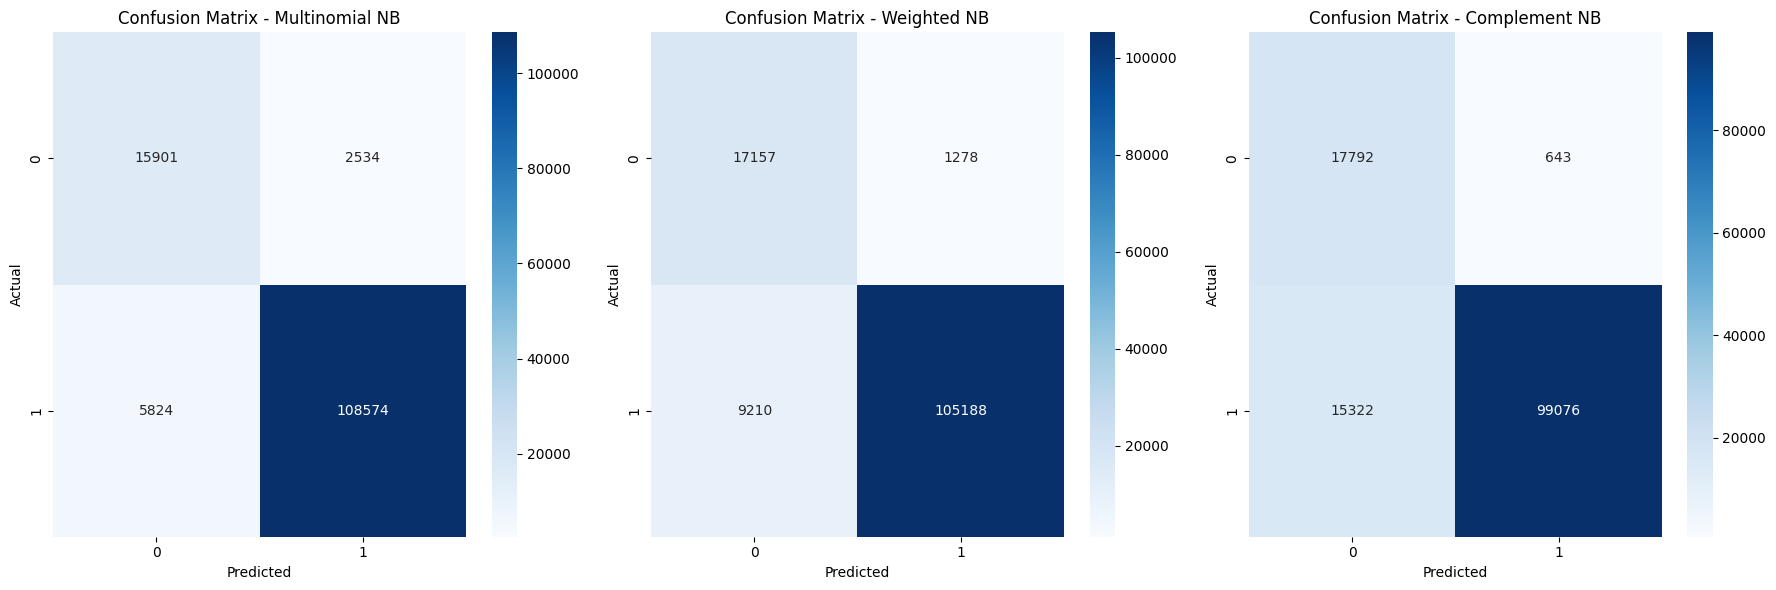

Metrics for Multinomial NB:
Accuracy: 0.9371
Precision: 0.9432
Recall: 0.9371
F1-score: 0.9392

Metrics for Weighted NB:
Accuracy: 0.8798
Precision: 0.9302
Recall: 0.8798
F1-score: 0.8928

Metrics for Complement NB:
Accuracy: 0.9210
Precision: 0.9412
Recall: 0.9210
F1-score: 0.9266



In [62]:
cm_multinomial = confusion_matrix(y_test, y_pred_multinomial)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
cm_complement = confusion_matrix(y_test, y_pred_complement)

combined_cm = np.array([cm_multinomial, cm_complement, cm_weighted])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
models = ['Multinomial NB', 'Weighted NB', 'Complement NB']

for i, (cm, model) in enumerate(zip(combined_cm, models)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

def print_metrics(y_true, y_pred, model_name):
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred, average='weighted'):.4f}\n")

print_metrics(y_test, y_pred_multinomial, "Multinomial NB")
print_metrics(y_test, y_pred_weighted, "Weighted NB")
print_metrics(y_test, y_pred_complement, "Complement NB")

y_pred_multinomial = multinomial_nb.predict_proba(X_test_vectorized)[:, 1]
y_pred_complement = complement_nb.predict_proba(X_test_vectorized)[:, 1]
y_pred_weighted = weighted_nb.predict_proba(X_test_vectorized)[:, 1]

fpr_multinomial, tpr_multinomial, _ = roc_curve(y_test, y_pred_multinomial)
fpr_complement, tpr_complement, _ = roc_curve(y_test, y_pred_complement)
fpr_weighted, tpr_weighted, _ = roc_curve(y_test, y_pred_weighted)

auc_multinomial = auc(fpr_multinomial, tpr_multinomial)
auc_complement = auc(fpr_complement, tpr_complement)
auc_weighted = auc(fpr_weighted, tpr_weighted)

## Long Short-Term Memory

Long Short-Term Memory or LSTM networks are a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. LSTM networks address the 'vanishing gradient' problem that affects typical RNNs, which makes them effective for tasks involving time series data and natural language processing.
The key feature of LSTMs is their memory cell, which is controlled by three logical gates: input, forget, and output. These gates regulate the flow of information, allowing the network to selectively retain or discard information over long sequences. This process enables LSTMs to learn and remember important patterns while ignoring irrelevant details.
LSTMs are knownr to have good performance in various applications, including:
1. Natural Language Processing - Machine translation, sentiment analysis, and text generation.
2. Speech Recognition - Transcribing speech to text and recognising spoken commands.
3. Time Series Forecasting - Predicting stock prices, weather patterns, and energy consumption.

### Performance

While LSTMs face competition from newer architectures like transformers which have shown to have with better results in similar tasks, they still maintain advantages in problems with limited data or where sequential processing is important for the result.
The effectiveness of LSTM models can be further improved through techniques such as bidirectional processing, stacking multiple layers and hyperparameter tuning. These optimisations let LSTMs to capture more complex patterns and adapt to specific problems better.

This LSTM implementation uses TensorFlow and Keras, I tried using PyTorch but there seems to be a lot of issues currently with their Metal API for running models directly on Apple Silicon processors.

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np
import pickle

# X_train, X_test, y_train, y_test = load_data('trainText.pkl')
X_train, X_test, y_train, y_test = load_data('trainCombined.pkl')

# Tokenization
max_words = 2000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 250
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


embedding_dim = 100
model = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=3, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/3
14944/14944 ━━━━━━━━━━━━━━━━━━━━ 346s 23ms/step - accuracy: 0.9440 - loss: 0.1466 - val_accuracy: 0.9613 - val_loss: 0.0997
Epoch 2/3
14944/14944 ━━━━━━━━━━━━━━━━━━━━ 345s 23ms/step - accuracy: 0.9633 - loss: 0.0967 - val_accuracy: 0.9627 - val_loss: 0.0942
Epoch 3/3
14944/14944 ━━━━━━━━━━━━━━━━━━━━ 343s 23ms/step - accuracy: 0.9655 - loss: 0.0897 - val_accuracy: 0.9647 - val_loss: 0.0923
4152/4152 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.9642 - loss: 0.0936
Test accuracy: 0.9639


In [64]:
# Tokenize and pad the new reviews
new_reviews_seq = tokenizer.texts_to_sequences(new_reviews)
new_reviews_pad = pad_sequences(new_reviews_seq)

# Make predictions
predictions = model.predict(new_reviews_pad)

print("\nPredictions for new reviews:")
for review, prediction in zip(new_reviews, predictions):
    sentiment = "Positive" if prediction[0] > 0.5 else "Negative"
    print(f"Review: {review}")
    print(f"Predicted sentiment: {sentiment} (Score: {prediction[0]:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Predictions for new reviews:
Review: I absolutely love this product! It exceeded all my expectations and has become an essential part of my daily routine. The quality is top-notch, and it works exactly as described. The design is sleek and modern, making it a great addition to my home. I highly recommend this to anyone looking for a reliable and efficient solution. Worth every penny!
Predicted sentiment: Positive (Score: 0.9998)

Review: I am very disappointed with this product. It did not meet my expectations at all. The quality feels cheap, and it stopped working properly after just a few uses. The description was misleading, and I feel like I wasted my money. I would not recommend this to anyone. Save your money and look for a better alternative.
Predicted sentiment: Negative (Score: 0.0113)

Review: The product is okay, but it has its pros and cons. It performs its basic functions as advertised, but there's nothing particularly outstanding abo

4152/4152 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step


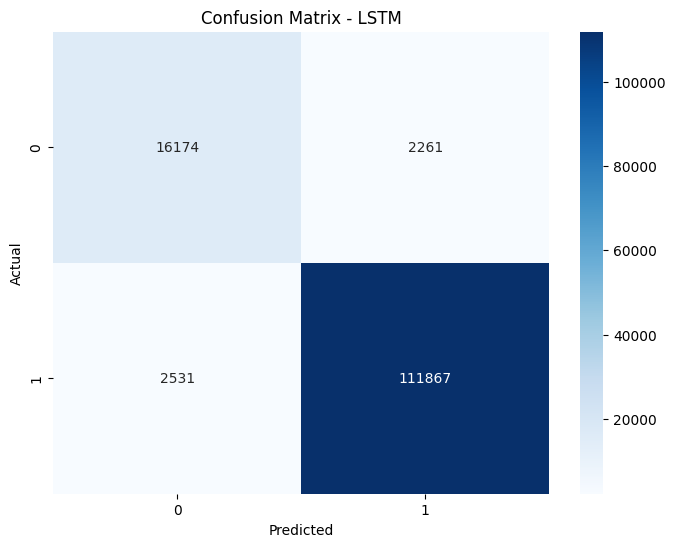

Metrics for LSTM:
Accuracy: 0.9639
Precision: 0.9642
Recall: 0.9639
F1-score: 0.9640



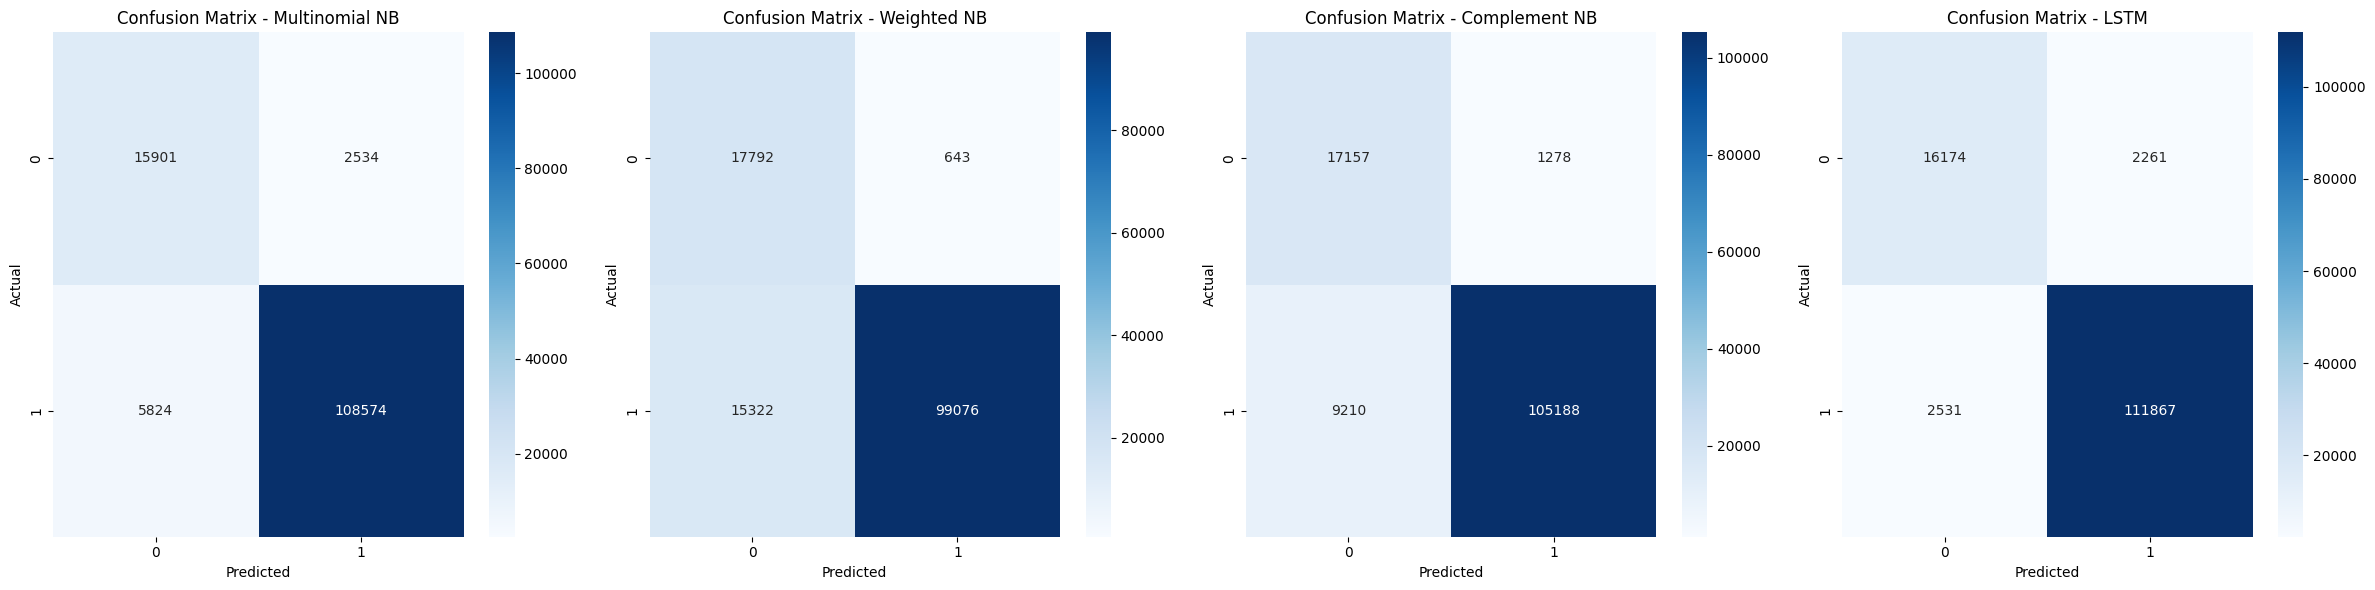

In [65]:
y_pred_lstm = model.predict(X_test_pad)
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype(int).flatten()
cm_lstm = confusion_matrix(y_test, y_pred_lstm_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

def print_metrics(y_true, y_pred, model_name):
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred, average='weighted'):.4f}\n")

print_metrics(y_test, y_pred_lstm_classes, "LSTM")

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
models = ['Multinomial NB', 'Weighted NB', 'Complement NB', 'LSTM']
confusion_matrices = [cm_multinomial, cm_weighted, cm_complement, cm_lstm]

for i, (cm, model) in enumerate(zip(confusion_matrices, models)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Evaluation

### Naive Bayes
Naive Bayes (Multinomial non-weighted) showed an accuracy score of 0.92, though it showed a bias towards positive sentiment, with higher precision and recall for the positive class.

Naive Bayes (Multinomial weighted) showed an lower acuuracy score of 0.81, and shows a bias towards the negative class when evaluating more neutral reviews. This aligns more with the original goal than the non-weighted NB.

Naive Bayes (Complement) shows an accuracy of 0.90 and provides a similar though slightly more balanced evaluation of the new reviews when compared to the weighted Multinomial. It has higher recall and F1 scores than the other two and provides the best overall Naive Bayes implementation for this problem.

Using the combined title and text data shows an improvement on all models on average of around 0.02 accuracy points.

### Long Short-Term Memory
LSTM outperformed Naive Bayes in overall accuracy, possibly due to its ability to capture context and long-term dependencies in text. However, when looking at the 'new reviews' output, it tends to score neutral reviews much lower indicating a bias towards the negative class. This algorithm also showed an improvement when given the combined

# Failed / Unnecessary Processing

In [66]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
# from collections import defaultdict
# import pickle
# import string
# import matplotlib
# %matplotlib inline

# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')

# dataset = load_data('nDataset.pkl')
# df = pd.DataFrame(dataset)

# def preprocess_text(text):
#     text = text.lower()
#     text = text.translate(str.maketrans("", "", string.punctuation))
#     tokens = word_tokenize(text)
#     stop_words = set(stopwords.words('english'))
#     ps = PorterStemmer()
#     tokens = [ps.stem(token) for token in tokens if token not in stop_words]
#     return tokens

# def calculate_word_counts(texts):
#     word_count = defaultdict(int)

#     for text in texts:
#         tokens = preprocess_text(text)

#         for token in tokens:
#             word_count[token] += 1

#     return word_count

# word_count_positive = calculate_word_counts(df[df['rating'] >=4.0]['text'])
# word_count_negative = calculate_word_counts(df[df['rating'] <=2.0]['text'])
# word_count_neutral = calculate_word_counts(df[df['rating'] == 3.0]['text'])

# word_count_positive_df = pd.DataFrame(word_count_positive.items(), columns=['Word', 'Count'])
# word_count_negative_df = pd.DataFrame(word_count_negative.items(), columns=['Word', 'Count'])
# word_count_neutral_df = pd.DataFrame(word_count_neutral.items(), columns=['Word', 'Count'])

# top_positive_words = word_count_positive_df.sort_values(by='Count', ascending=False).head(20)
# top_negative_words = word_count_negative_df.sort_values(by='Count', ascending=False).head(20)
# top_neutral_words = word_count_neutral_df.sort_values(by='Count', ascending=False).head(20)

# print("Top 20 Words - Positive Sentiment:")
# display(top_positive_words)

# print("\nTop 20 Words - Negative Sentiment:")
# display(top_negative_words)

# print("\nTop 20 Words - Neutral Sentiment:")
# display(top_neutral_words)

# df['token_text'] = df['text'].apply(preprocess_text)
# df.info()

# save_data(df, 'tDataset.pkl')

In [67]:
# def load_and_preprocess_data(filename, min_length=15, min_words=5, non_informative=['pictur', 'ear', 'none', 'look', 'like', '’', 'one']):
#     df = pd.DataFrame(load_data(filename))

#     df.info()

#     df['token_text'] = df['token_text'].astype(str)
#     df['review_length'] = df['token_text'].str.len()
#     df['word_count'] = df['token_text'].str.split().str.len()

#     length_mask = df['review_length'] >= min_length
#     word_count_mask = df['word_count'] >= min_words
#     content_mask = ~df['token_text'].str.lower().isin(non_informative)

#     combined_mask = length_mask & word_count_mask & content_mask

#     df_filtered = df[combined_mask]
#     removed_reviews = df[~combined_mask]

#     df_filtered.info()

#     save_data(df_filtered, 'pDataset.pkl')

#     print_removal_stats(df, length_mask, word_count_mask, content_mask)
#     print_dataset_stats(df, df_filtered)

#     return df_filtered, removed_reviews

# def print_removal_stats(df, length_mask, word_count_mask, content_mask):
#     print(f"Reviews removed due to length: {(~length_mask).sum()}")
#     print(f"Reviews removed due to word count: {(~word_count_mask).sum()}")
#     print(f"Reviews removed due to non-informative content: {(~content_mask).sum()}")

# def print_dataset_stats(original_df, filtered_df):
#     print(f"Original dataset size: {len(original_df)}")
#     print(f"Filtered dataset size: {len(filtered_df)}")
#     print(f"Number of reviews removed: {len(original_df) - len(filtered_df)}")

# # Usage
# df_filtered, removed_reviews = load_and_preprocess_data('tDataset.pkl')
# display(removed_reviews)


In [68]:
# balance = load_data('pDataset.pkl')
# df = pd.DataFrame(balance)
# df = df.drop(columns=['title', 'text', 'verified_purchase', 'review_length', 'word_count'])

# display(df)

# def balance_reviews(df, max_reviews_per_category=20000):

#     balanced_df = df.groupby('rating').apply(
#         lambda x: x.sample(n=min(len(x), max_reviews_per_category), random_state=42)
#     ).reset_index(drop=True)

#     return balanced_df

# balanced_df = balance_reviews(df)
# save_data(balanced_df, 'bDataset.pkl')

# train = load_data('bDataset.pkl')
# split = pd.DataFrame(train)
# # Split the data into testing and training sets
# X_train, X_test, y_train, y_test = train_test_split(df['token_text'], df['rating'], test_size=0.8, random_state=42)

# save_data((X_train, X_test, y_train, y_test), 'training_data.pkl')

## Support Vector Machine (Failed)

In [69]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report

# # Initialize and train the SVM classifier
# svm_classifier = SVC(kernel='linear')
# svm_classifier.fit(X_train_vectorized, y_train)

# # Make predictions on the test set
# y_pred = svm_classifier.predict(X_test_vectorized)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# new_reviews = [
#     "This product exceeded my expectations. Highly recommended!",
#     "Terrible experience. Would not buy again.",
#     "Average product, nothing special."
# ]
# new_reviews_vectorized = vectorizer.transform(new_reviews)
# new_predictions = svm_classifier.predict(new_reviews_vectorized)

# print("\nPredictions for new reviews:")
# for review, prediction in zip(new_reviews, new_predictions):
#     print(f"Review: {review}")
#     print(f"Predicted sentiment: {prediction}\n")